In [1]:
# 데이터 불러오기

import pandas as pd
import numpy as np
import time

print('종목 차트정보 가져오는 중...')
dailychart = pd.read_csv('dailychart.csv')
dailychart['date'] = pd.to_datetime(dailychart['date'], format='%Y%m%d')

print("종목정보 가져오는 중...")
stockitems_original = pd.read_csv('stockItems.csv')   #종목정보 가져오기
stockitems_in_chart = dailychart['code'].unique()
stockitems = stockitems_original.loc[stockitems_original['code'].isin(stockitems_in_chart)]

# 날짜 데이터프레임 생성
df_date = pd.DataFrame(dailychart['date'].unique(), columns=['date'])
min_day = np.min(dailychart['date'])
max_day = np.max(dailychart['date'])

print("지수정보 가져오는 중...")
dailychart_index = pd.read_csv('dailychart_index.csv')   #종목정보 가져오기

dailychart_index['date'] = pd.to_datetime(dailychart_index['date'], format='%Y%m%d')
dailychart_index = dailychart_index.loc[(min_day <= dailychart_index['date']) & ( dailychart_index['date'] <= max_day)].reset_index(drop=True)
dailychart_KOSPI = dailychart_index.loc[dailychart_index['section'] == 'KOSPI'].reset_index(drop=True)
dailychart_KOSDAQ = dailychart_index.loc[dailychart_index['section'] == 'KOSDAQ'].reset_index(drop=True)


df_date['idx'] = df_date.index
# 각 종목별 시작일에 날짜 인덱스를 추가
tmp_df = pd.merge(dailychart.groupby('code', as_index=False)['date'].min(), df_date, on='date' )


# 종목 데이터에 종목별 시작일과 시작날짜 인덱스를 조인
stockitems = pd.merge(stockitems_original, tmp_df, on='code')
stockitems = stockitems.rename(columns = {'date':'firstdate', 'idx':'idx_firstdate'})


print('데이터를 불러왔습니다.')




종목 차트정보 가져오는 중...
종목정보 가져오는 중...
지수정보 가져오는 중...
데이터를 불러왔습니다.


In [2]:
# 벡터연산 기반 시뮬레이션


column_tradelog = ['code', 'name', 'section', 'idx_buydate', 'buydate','buyprice', 'idx_selldate', 'selldate', 'sellprice', 'period', 'rate','buy_index','sell_index','rate_index']
tradelog = pd.DataFrame(columns= column_tradelog)

n_test = 100000
np.random.seed(0)

print('투자 시뮬레이션을 시작합니다.')
start = time.time()

tradelog[['code','name', 'section', 'idx_firstdate']] = stockitems.loc[np.random.randint(0, len(stockitems), size=n_test), ['code', 'name', 'section','idx_firstdate']]

tradelog['idx_buydate'] = tradelog.apply(lambda x: np.random.randint(x['idx_firstdate'], len(df_date)-1) ,axis = 1)
tradelog['buydate'] = df_date.loc[tradelog['idx_buydate'],'date'].to_numpy()
tradelog = pd.merge(tradelog, dailychart[['code','date','low','high']], left_on=['code','buydate'],  right_on=['code','date'], how='left')
tradelog['buyprice'] = np.random.randint(tradelog['low'], tradelog['high']+1)
tradelog = tradelog.drop(columns=['low', 'high'])

tradelog['idx_selldate'] = tradelog['idx_buydate'] + np.random.randint(1, len(df_date) - tradelog['idx_buydate'])
tradelog['selldate'] = df_date.loc[tradelog['idx_selldate'],'date'].to_numpy()
tradelog = pd.merge(tradelog, dailychart[['code','date','low','high']], left_on=['code','selldate'],  right_on=['code','date'], how='left')
tradelog['sellprice'] = np.random.randint(tradelog['low'], tradelog['high']+1)
tradelog = tradelog.drop(columns=['low', 'high'])
tradelog['period'] = tradelog['idx_selldate'] - tradelog['idx_buydate']
tradelog['rate'] = (tradelog['sellprice'] - tradelog['buyprice']) / tradelog['buyprice'] * 100

tradelog['buy_index'] = dailychart_KOSPI.loc[tradelog['idx_buydate'], 'close'].to_numpy()
tradelog['sell_index'] = dailychart_KOSPI.loc[tradelog['idx_selldate'], 'close'].to_numpy()
tradelog_index_KOSDAQ = tradelog.loc[tradelog['section'] == 'KOSDAQ'].index
tradelog.loc[tradelog_index_KOSDAQ, 'buy_index'] = dailychart_KOSDAQ.loc[tradelog.loc[tradelog_index_KOSDAQ,'idx_buydate'], 'close'].to_numpy()
tradelog.loc[tradelog_index_KOSDAQ, 'sell_index'] = dailychart_KOSDAQ.loc[tradelog.loc[tradelog_index_KOSDAQ,'idx_selldate'], 'close'].to_numpy()

tradelog['rate_index'] =  (tradelog['sell_index'] - tradelog['buy_index']) / tradelog['buy_index'] * 100

#불필요한 컬럼 제거
tradelog = tradelog.drop(columns=['date_x','date_y', 'idx_firstdate'])

print('time : ', time.time() - start)
print('투자 시뮬레이션 데이터 로그를 저장합니다.')

tradelog.to_csv('tradelog3.csv')
print('시뮬레이션 데이터 로그를 저장하였습니다.')

    

투자 시뮬레이션을 시작합니다.
time :  2.798060178756714
투자 시뮬레이션 데이터 로그를 저장합니다.
시뮬레이션 데이터 로그를 저장하였습니다.


In [4]:
# for문 기반 시뮬레이션

rows = list()

#dailychart = pd.merge(dailychart, stockitems, on=['code'])

column_tradelog = ['code', 'name', 'section', 'idx_buydate', 'buydate','buyprice', 'idx_selldate', 'selldate', 'sellprice', 'period', 'rate','buy_index','sell_index','rate_index']

n_test = 200
np.random.seed(0)

print('투자 시뮬레이션을 시작합니다.')

start = time.time()

for i in range(0,n_test):
    code, name, section = stockitems.loc[np.random.randint(0, len(stockitems)), ['code', 'name', 'section']]
    df_sub =  dailychart.loc[dailychart['code'] == code].reset_index()
    idx_firstday = df_date.loc[df_date['date'] == df_sub.loc[0, 'date']].index[0]
    idx_buydate= np.random.randint(idx_firstday, len(df_date)-1)
    buydate = df_date.loc[idx_buydate, 'date']
    #buydate = array_date.where(np.random.randint(0, array_date))

    daychart = df_sub.loc[df_sub['date'] == buydate].reset_index(drop=True)
    buyprice = np.random.randint(daychart.loc[0,'low'], daychart.loc[0,'high']+1)
    # 실제는 단위가 1이 아니지만 일단 편의상 1로 함

    period = len(df_date) - idx_buydate
    idx_selldate = idx_buydate + np.random.randint(1, period)
    selldate = df_date.loc[idx_selldate, 'date']
    
    daychart = df_sub.loc[df_sub['date'] == selldate].reset_index(drop=True)
    sellprice =  np.random.randint(daychart.loc[0, 'low'], daychart.loc[0, 'high']+1)
    invest_period = idx_selldate - idx_buydate
    rate = (sellprice - buyprice) / buyprice * 100
    if section == 'KOSDAQ': # 코스닥인 경우
        buy_index = dailychart_KOSDAQ.loc[idx_buydate, 'close']
        sell_index = dailychart_KOSDAQ.loc[idx_selldate, 'close']
    else:
        buy_index = dailychart_KOSPI.loc[idx_buydate, 'close']
        sell_index = dailychart_KOSPI.loc[idx_selldate, 'close']
        
    rate_index =  (sell_index - buy_index) / buy_index * 100
        
    row = [code, name,  section, idx_buydate, buydate, buyprice, idx_selldate, selldate, sellprice, invest_period, rate, buy_index, sell_index, rate_index]
    rows.append(row)
    if i % 100 == 0:
        print(i)

print('time : ', time.time() - start)
print('투자 시뮬레이션 데이터 로그를 저장합니다.')
tradelog = pd.DataFrame(data = rows, columns= column_tradelog)

tradelog.to_csv('tradelog2.csv')
print('시뮬레이션 데이터 로그를 저장하였습니다.')



투자 시뮬레이션을 시작합니다.
0
100
time :  36.935518980026245
투자 시뮬레이션 데이터 로그를 저장합니다.
시뮬레이션 데이터 로그를 저장하였습니다.


In [5]:
tradelog['net_rate'] = tradelog['rate'] - tradelog['rate_index']
tradelog.describe()

,idx_buydate,buyprice,idx_selldate,sellprice,period,rate,buy_index,sell_index,rate_index,net_rate
count,100000.000000,1.000000e+05,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1097.887290,2.151344e+04,1445.829020,2.197456e+04,347.941730,13.702470,1518.146901,1652.946859,10.480117,3.222353
std,520.129257,5.705542e+04,360.038521,5.747723e+04,361.610964,83.898861,813.737106,893.613601,19.361336,82.093481
min,0.000000,8.300000e+01,10.000000,6.200000e+01,1.000000,-99.812236,428.350006,428.350006,-51.680221,-177.369213
25%,684.000000,3.832750e+03,1271.000000,3.803000e+03,66.000000,-15.542792,694.659973,807.849976,-1.532391,-24.633075
50%,1199.000000,8.860000e+03,1575.000000,8.901000e+03,218.000000,0.288302,1888.300049,1879.125000,5.823155,-4.086425
75%,1561.000000,1.699675e+04,1727.000000,1.802025e+04,522.000000,19.725553,2157.179932,2349.550049,21.109935,9.956889
max,1791.000000,1.768173e+06,1792.000000,1.662114e+06,1788.000000,5226.899128,3208.989990,3208.989990,136.698963,5214.251084


In [6]:
tradelog_minrate = tradelog.sort_values('rate').head(10)
tradelog_maxrate = tradelog.sort_values('rate', ascending=False).head(10)

In [9]:
tradelog_minrate

,code,name,section,buydate_index,buydate,buyprice,selldate_index,selldate,sellprice,period,rate,buy_index,sell_index,index_rate,net_rate
31061,A071970,STX중공업,KOSPI,5,2014-01-09,1768173,1364,2019-07-24,3320,1359,-99.812236,1946.109985,2082.300049,6.998066,-106.810302
50332,A071970,STX중공업,KOSPI,313,2015-04-13,665410,1522,2020-03-16,1710,1209,-99.743016,2098.919922,1714.859985,-18.297979,-81.445036
28310,A071970,STX중공업,KOSPI,243,2014-12-29,665409,1498,2020-02-11,2735,1255,-99.588975,1927.859985,2223.120117,15.315434,-114.904409
13335,A071970,STX중공업,KOSPI,261,2015-01-26,665409,1785,2021-04-08,4101,1524,-99.383687,1935.680054,3143.260010,62.385308,-161.768995
65352,A071970,STX중공업,KOSPI,86,2014-05-09,665409,1648,2020-09-15,4584,1562,-99.311100,1956.550049,2443.580078,24.892286,-124.203386
39483,A071970,STX중공업,KOSPI,179,2014-09-25,665409,1286,2019-04-02,5835,1107,-99.123096,2034.109985,2177.179932,7.033540,-106.156636
90765,Q500019,신한 레버리지 WTI원유 선물 ETN(H),KOSPI,1111,2018-07-12,21244,1702,2020-12-04,349,591,-98.357183,2285.060059,2731.449951,19.535149,-117.892332
70105,A071970,STX중공업,KOSPI,462,2015-11-17,367067,1260,2019-02-22,6411,798,-98.253452,1963.579956,2230.500000,13.593541,-111.846993
69912,A141020,포티스,KOSDAQ,598,2016-06-09,5899,1744,2021-02-05,108,1146,-98.169181,705.080017,967.419983,37.207120,-135.376301
47508,A001260,남광토건,KOSPI,109,2014-06-13,379915,801,2017-04-03,6979,692,-98.163010,1990.849976,2167.510010,8.873599,-107.036609


[[1.         0.10700935]
 [0.10700935 1.        ]]


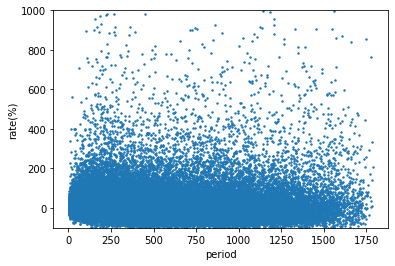

In [107]:
# 투자기간에 따른 수익률 비교

import matplotlib.pyplot as plt

fig = plt.figure()
s = plt.scatter(x=tradelog2['period'], y=tradelog2['rate'], s=2)
plt.xlabel('period')
plt.ylabel('rate(%)')
plt.ylim(-100,1000)

print(np.corrcoef(tradelog2['period'], tradelog2['rate']))  #투자기간과 수익률의  상관관계

(-100.0, 1000.0)

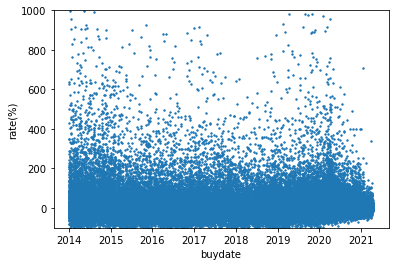

In [21]:
#  투자시기에 따른 수익률 비교

import matplotlib.pyplot as plt

fig = plt.figure()
s = plt.scatter(x=tradelog2['buydate'], y=tradelog2['rate'], s=2)
plt.xlabel('buydate')
plt.ylabel('rate(%)')
plt.ylim(-100,1000)

#print(np.corrcoef(tradelog2['buydate'], tradelog2['rate']))  #투자기간과 수익률의  상관관계

In [74]:
tradelog2 = tradelog.sort_values(['buydate', 'period'])

tradelog2['buydate_year'] = tradelog2['buydate'].dt.year

bins = [0, 5, 10, 21, 63, 126, 252]   # 1주, 2주, 1개월, 3개월, 6개월, 1년, 1년 초과 단위
tradelog2['cat_period'] = np.digitize(tradelog2['period'], bins, right=False)

stats_tradelog_by_year_period = tradelog2.groupby(['buydate_year','cat_period'], dropna=False)
stats_tradelog_by_year_period_mean = stats_tradelog_by_year_period.mean()['rate'].unstack(1)  # 데이터 프레임으로 변환

stats_tradelog_by_year_period_mean

cat_period,1,2,3,4,5,6,7
buydate_year,,,,,,,
2014,-0.086073,-0.754067,-0.834265,4.605405,16.470442,28.443048,51.683830
2015,-0.830320,-1.176659,2.344035,8.213329,4.072366,12.782692,19.924287
2016,0.610013,-0.251899,1.717762,1.255903,3.566101,4.199487,11.405180
2017,0.053250,1.010071,1.434121,1.348300,5.542926,8.595064,9.109776
2018,0.015615,0.411161,-0.787928,-1.299186,-1.086662,-2.747470,4.016428
2019,-0.220800,0.538946,1.523958,0.691981,-2.480231,6.526126,23.292135
2020,0.446927,1.272378,2.447000,8.093615,18.253562,37.539313,46.237892
2021,0.487481,0.909210,1.705912,1.959710,5.542771,NaN,NaN


In [105]:
print(len(tradelog2.query( "cat_period == 1" )))
print(len(tradelog2.query( "cat_period == 2" )))
print(len(tradelog2.query( "cat_period == 3" )))
print(len(tradelog2.query( "cat_period == 4" )))
print(len(tradelog2.query( "cat_period == 5" )))
print(len(tradelog2.query( "cat_period == 6" )))


3625
3047
4989
12555
12731
16806


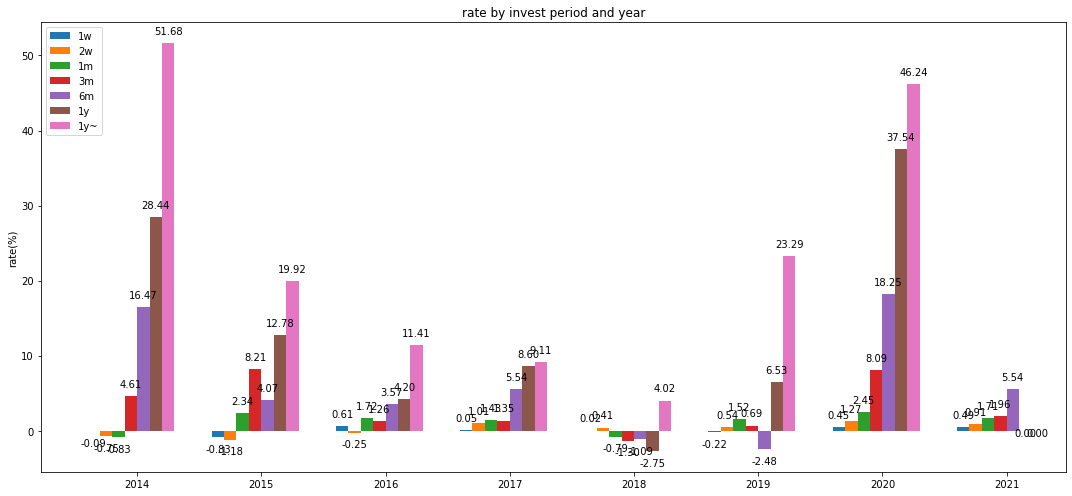

In [106]:
# 바 플롯 만들기


# 통계 집계대상 범주화

tradelog2 = tradelog.sort_values(['buydate', 'period'])

tradelog2['buydate_year'] = tradelog2['buydate'].dt.year

bins = [0, 5, 10, 21, 63, 126, 252]   # 1주, 2주, 1개월, 3개월, 6개월, 1년, 1년 초과 단위
tradelog2['cat_period'] = np.digitize(tradelog2['period'], bins, right=False)

stats_tradelog_by_year_period = tradelog2.groupby(['buydate_year','cat_period'])
stats_tradelog_by_year_period_mean = stats_tradelog_by_year_period.mean()['rate'].unstack(1)  # 데이터 프레임으로 변환


## 필요 모듈 임포트
import matplotlib.pyplot as plt

category_labels = list(np.sort(tradelog['buydate'].dt.year.unique()).astype(str))
subcategory_labels = ['1w', '2w', '1m', '3m', '6m', '1y', '1y~']

x = np.arange(len(category_labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width*(7/2), stats_tradelog_by_year_period_mean[1], width, label=subcategory_labels[0])
rects2 = ax.bar(x - width*(5/2), stats_tradelog_by_year_period_mean[2], width, label=subcategory_labels[1])
rects3 = ax.bar(x - width*(3/2), stats_tradelog_by_year_period_mean[3], width, label=subcategory_labels[2])
rects4 = ax.bar(x - width*(1/2), stats_tradelog_by_year_period_mean[4], width, label=subcategory_labels[3])
rects5 = ax.bar(x + width*(1/2), stats_tradelog_by_year_period_mean[5], width, label=subcategory_labels[4])
rects6 = ax.bar(x + width*(3/2), stats_tradelog_by_year_period_mean[6], width, label=subcategory_labels[5])
rects7 = ax.bar(x + width*(5/2), stats_tradelog_by_year_period_mean[7], width, label=subcategory_labels[6])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('rate(%)')
ax.set_title('rate by invest period and year')
ax.set_xticks(x)
ax.set_xticklabels(category_labels)
ax.legend()

ax.bar_label(rects1, padding=7, fmt='%.2f')
ax.bar_label(rects2, padding=7, fmt='%.2f')
ax.bar_label(rects3, padding=7, fmt='%.2f')
ax.bar_label(rects4, padding=7, fmt='%.2f')
ax.bar_label(rects5, padding=7, fmt='%.2f')
ax.bar_label(rects6, padding=7, fmt='%.2f')
ax.bar_label(rects7, padding=7, fmt='%.2f')

fig.tight_layout()

plt.show()

In [8]:
dailychart = pd.read_csv('dailychart.csv')

In [10]:
dailychart.columns

Index(['code', 'section', 'date', 'open', 'high', 'low', 'close', 'vol',
       'value', 'n_stock', 'agg_price', 'foreign_rate', 'agency_buy',
       'agency_netbuy'],
      dtype='object')